# OpenCv warpPerspective vs Tensorflow transform

To run the jupyter-notebook from inside a virtualenv, see:
- http://help.pythonanywhere.com/pages/IPythonNotebookVirtualenvs
- https://ipython.readthedocs.io/en/latest/install/kernel_install.html

## OpenCv

OpenCv [warpPerspective](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective) takes 3×3 matrix

$$M_{opencv} = \left| \begin{matrix}
    a_1 & a_2 & a_3 \\
    b_1 & b_2 & b_3 \\
    c_1 & c_2 & c_3 \end{matrix} \right|$$

if WARP_INVERSE_MAP is set the mapping is computed as follows


$$dst(x,y) = src \left( \frac{a_1 x + a_2 y + a_3}{k}, \frac{b_1 x + b_2 y + b_3}{k}\right); k = c_1 x + c_2 y + c_3$$


## Tensorflow

[Tensorflow.contrib.image.transform](https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform) expects a matrix

$$M_{tensorflow} = \left| \begin{matrix}
    a_1 & a_2 & a_3 \\
    b_1 & b_2 & b_3 \\
    c_1 & c_2 &  \end{matrix} \right|$$

And the pixel in destination image is computed by

$$dst(x, y) = src\left( \frac{\left(a_1 x + a_2 y + a_3\right)}{k}, \frac{\left(b_1 x + b_2 y + b_3\right)}{k} \right); k = c_1 x + c_2 y + 1$$

Notice the constant $1$ in $k$ element which implies the transform matrix has to be divided by its last element if it is not equal to $1$.



## Define parameters to create a final transform

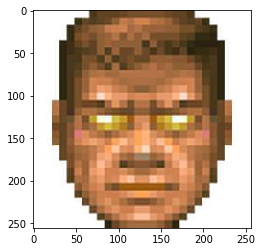

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from __future__ import division

IMAGE="files/ps-doom.jpg"
#Field of View
FOV=30
# Rotation about x, y, and z
ROT_VEC = np.deg2rad([70,0,0])
# Translation along x, y, and z
TRANSLATE_VEC = [0,20,0]

# Read image
img = mpimg.imread(IMAGE)

# Parameters to construct elementary transformations
img_center = [dim // 2 for dim in img.shape[:2]]
# Compute the distance/focal length given the field of view
distance = (img.shape[0] // 2) / np.tan(np.deg2rad(FOV // 2))
cos_rot_vec = np.cos(ROT_VEC)
sin_rot_vec = np.sin(ROT_VEC)
# Selection indices
rows_id = np.asarray([0, 1, 3])
rows_id = rows_id[:, np.newaxis]

plt.imshow(img)

## Create Model, View, and Projection matrices

In [2]:
# Translate image to be rotated according its center
translate = np.asarray([[1, 0, 0, -img_center[1]],
                        [0, 1, 0, -img_center[0]],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

# Prepare rotation matrix
rot_x = np.asarray([[1, 0, 0, 0],
                    [0, cos_rot_vec[0], -sin_rot_vec[0], 0],
                    [0, sin_rot_vec[0], cos_rot_vec[0], 0],
                    [0, 0, 0, 1]])

rot_y = np.asarray([[cos_rot_vec[1], 0, sin_rot_vec[1], 0],
                    [0, 1, 0, 0],
                    [-sin_rot_vec[1], 0, cos_rot_vec[1], 0],
                    [0, 0, 0, 1]])

rot_z = np.asarray([[cos_rot_vec[2], -sin_rot_vec[2], 0, 0],
                    [sin_rot_vec[2], cos_rot_vec[2], 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

rot = rot_z.dot(rot_y.dot(rot_x))

# Define translation
move = np.asarray([[1, 0, 0, TRANSLATE_VEC[0]],
                   [0, 1, 0, TRANSLATE_VEC[1]],
                   [0, 0, 1, TRANSLATE_VEC[2]],
                   [0, 0, 0, 1]])

# Create Model matrix
model = move.dot(rot.dot(translate))

# Define View matrix, move the camera along z
view = np.asarray([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, distance],
                   [0, 0, 0, 1]])

# Define projection matrix with principal point based on image center
# See http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
projection = np.asarray([[1, 0, img_center[1]/distance, 0],
                         [0, 1, img_center[0]/distance, 0],
                         [0, 0, 1, 0],
                         [0, 0, 1./distance, 0]])
#projection = np.asarray([[distance, 0, img_center[1], 0],
#                         [0, distance, img_center[0], 0],
#                         [0, 0, 1, 0],
#                         [0, 0, 1, 0]])

## Create final matrix

In [3]:
mat4 = projection.dot(view.dot(model))
print(mat4)
# Invert it, OpenCv and Tensorflow will map destination to source
#mat4 = np.linalg.pinv(mat4)
# Select only the 3×3 part
mat3 = mat4[rows_id, [0,1,3]]
print(mat3/mat3[2,2]) 
mat3 = np.linalg.pinv(mat3)
#mat3 = mat4[rows_id, [0,1,3]]
print(mat3)


[[  1.00000000e+00   2.51789879e-01   9.16440212e-02  -3.22291045e+01]
 [  0.00000000e+00   5.93810022e-01  -8.48048600e-01   7.19923172e+01]
 [  0.00000000e+00   9.39692621e-01   3.42020143e-01   3.57421848e+02]
 [  0.00000000e+00   1.96710843e-03   7.15968916e-04   7.48210121e-01]]
[[  1.33652295e+00   3.36522952e-01  -4.30749379e+01]
 [  0.00000000e+00   7.93640724e-01   9.62193843e+01]
 [  0.00000000e+00   2.62908556e-03   1.00000000e+00]]
[[  1.00000000e+00  -8.31873806e-01   1.23117323e+02]
 [ -5.24810449e-16   2.47196752e+00  -2.37851192e+02]
 [ -7.60708639e-17  -6.49901411e-03   1.96185409e+00]]


## OpenCv

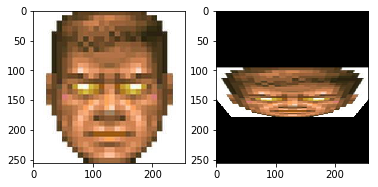

In [4]:
warped_image = cv2.warpPerspective(img,
                                   mat3,
                                   (img.shape[1], img.shape[0]),
                                   borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_AREA | cv2.WARP_INVERSE_MAP,
                                   borderValue=(0,0,0))
#plt.imshow(warped_image)

plt.subplot(1, 2, 1); plt.imshow(img)
plt.subplot(1, 2, 2); plt.imshow(warped_image)

## Tensorflow

Matrix scaled to have last element equal to 1
[[  5.09721903e-01  -4.24024300e-01   6.27555964e+01]
 [ -2.67507381e-16   1.26001599e+00  -1.21237962e+02]
 [ -3.87749855e-17  -3.31268984e-03   1.00000000e+00]]


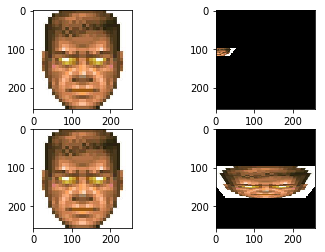

In [5]:
# Tensorflow expect the last matrix element is equal to 1
mat3s = mat3 / mat3[2,2]
print("Matrix scaled to have last element equal to 1")
print(mat3s)

sess = tf.InteractiveSession()

tensor_img = tf.constant(img/255., dtype=tf.float32)
tensor_mat_w = tf.constant(mat3.reshape([9])[:8], dtype=tf.float32)
tensor_mat = tf.constant(mat3s.reshape([9])[:8], dtype=tf.float32)

tf_warp_w = tf.contrib.image.transform(tensor_img,
                           tensor_mat_w,
                           interpolation="NEAREST")

tf_warp = tf.contrib.image.transform(tensor_img,
                           tensor_mat,
                           interpolation="NEAREST")

tf_warped_img_w = tf_warp_w.eval()
tf_warped_img = tf_warp.eval()

sess.close()

plt.subplot(2, 2, 1); plt.imshow(img)
plt.subplot(2, 2, 2); plt.imshow(tf_warped_img_w)
plt.subplot(2, 2, 3); plt.imshow(img)
plt.subplot(2, 2, 4); plt.imshow(tf_warped_img)